In [1]:
from pathlib import Path
import h5py as h5
from vector import MomentumNumpy4D
import numpy as np
from numpy.lib.recfunctions import unstructured_to_structured
import matplotlib.pyplot as plt
import mplhep as mh
mh.style.use('CMS')

In [2]:
def convert_rec_nu_to_vector(arr):
    arr = np.concatenate(
        [
            arr,
            np.zeros((len(arr), 1))
        ],
        axis=1,
    )
    
    arr = unstructured_to_structured(
        arr=arr,
        dtype=np.dtype([('px', 'f4'), ('py', 'f4'), ('pz', 'f4'), ('mass', 'f4')]),
    )
    
    arr = MomentumNumpy4D(arr)
    return arr

In [3]:
dataset_file_path = Path('/users/seyang/data/nuflows/TTto2L2Nu/data_nb-ge-2/test.h5')
if not dataset_file_path.exists():
    raise FileNotFoundError(f'{dataset_file_path=}')
with h5.File(dataset_file_path) as file:
    gen_nu_arr, gen_antinu_arr = file['delphes']['neutrinos'][:].T
gen_nu_arr = MomentumNumpy4D(gen_nu_arr)
gen_antinu_arr = MomentumNumpy4D(gen_antinu_arr)

gen = {
    'nu': gen_nu_arr,
    'antinu': gen_antinu_arr,
}

In [4]:
result_file_path = Path('../logs/nu2flows/nb-ge-2/outputs/test-1024.h5')
if not result_file_path.exists():
    raise FileNotFoundError(f'{result_file_path=}')

rec_nu_arr_list = []
rec_antinu_arr_list = []
sample_size_list = 2 ** np.arange(11)
with h5.File(result_file_path) as file:
    arr = {key: value[:] for key, value in file.items()}
    for key in ['neutrino', 'antineutrino']:
        # arr['neutrino'][23953, 574, 0] gives -inf # px
        arr[key] = np.nan_to_num(arr[key], copy=True, nan=0.0, posinf=+1e4, neginf=-1e4)

    
    for sample_size in sample_size_list:
        print(f'{sample_size=}')
        subset_slice = (slice(None, None), slice(None, sample_size))
        subset = {key: value[subset_slice] for key, value in arr.items()}
    
        rec_mode_idx = subset['log_probs'].argmax(axis=1)
        rec_mode_idx = rec_mode_idx[:, None, None]
    
        rec_nu_arr = np.take_along_axis(subset['neutrino'], indices=rec_mode_idx, axis=1).squeeze()
        rec_antinu_arr = np.take_along_axis(subset['antineutrino'], indices=rec_mode_idx, axis=1).squeeze()

        rec_nu_arr = convert_rec_nu_to_vector(rec_nu_arr)
        rec_antinu_arr = convert_rec_nu_to_vector(rec_antinu_arr)

        rec_nu_arr_list.append(rec_nu_arr)
        rec_antinu_arr_list.append(rec_antinu_arr)

rec = {
    'nu': rec_nu_arr_list,
    'antinu': rec_antinu_arr_list,
}

sample_size=np.int64(1)
sample_size=np.int64(2)
sample_size=np.int64(4)
sample_size=np.int64(8)
sample_size=np.int64(16)
sample_size=np.int64(32)
sample_size=np.int64(64)
sample_size=np.int64(128)
sample_size=np.int64(256)
sample_size=np.int64(512)
sample_size=np.int64(1024)


In [15]:
output = {}

for component in ['pt', 'eta', 'phi']:
    output[component] = {}
    for nu_type in ['nu', 'antinu']:
        output[component][nu_type] = {key: [] for key in ['bias', 'resolution']}

        gen_nu = gen[nu_type]
        for sample_size_idx, rec_nu in enumerate(rec[nu_type]):
            if component == 'phi':
                residual = rec_nu.deltaphi(gen_nu)
            else:
                residual = getattr(rec_nu, component) - getattr(gen_nu, component)

            if np.any(np.isinf(residual)):
                sample_size = sample_size_list[sample_size_idx]
                print(f'{component=}, {nu_type=}, {sample_size=}')
                print(f'{residual.min()} - {residual.max()}')
            output[component][nu_type]['bias'].append(np.mean(residual))
            output[component][nu_type]['resolution'].append(np.std(residual))

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7, 7)
plt.rcParams['lines.markersize'] = 16

In [39]:
def plot(component, metric, sample_size_list, output):
    fig, ax = plt.subplots()
    ax.plot(sample_size_list, output[component]['nu'][metric], label=r'$ \nu $', marker='s', ls='--', lw=2)
    ax.plot(sample_size_list, output[component]['antinu'][metric], label=r'$ \tilde{\nu} $', marker='o', ls='-.', lw=2)
    ax.legend()
    ax.set_xlabel(r'Sampling Size')
    ax.set_ylabel(f'{component} {metric}')
    ax.axhline(0, color='gray', ls=':', lw=2)
    ax.set_xscale('log')
    return fig

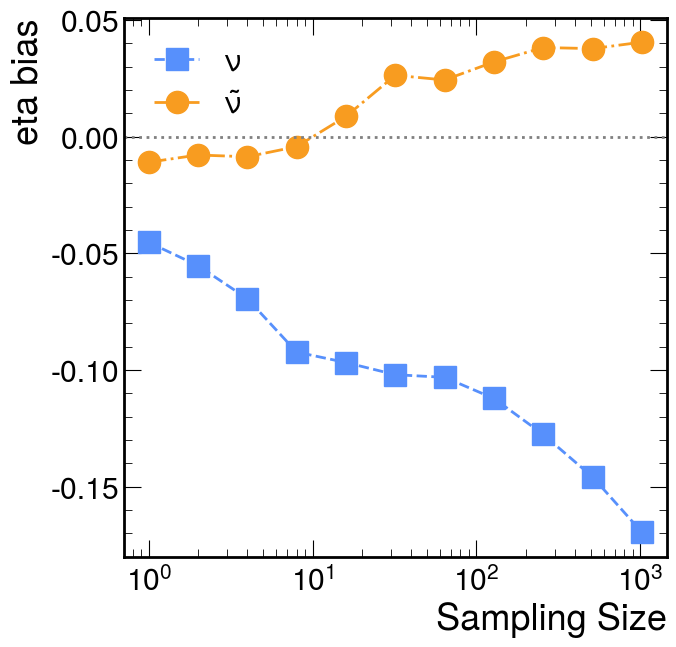

In [40]:
fig = plot('eta', 'bias', sample_size_list, output)

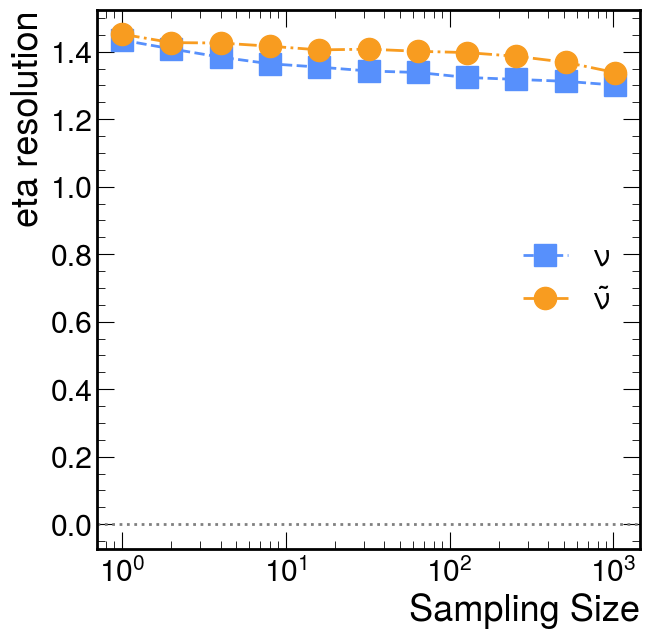

In [41]:
fig = plot('eta', 'resolution', sample_size_list, output)

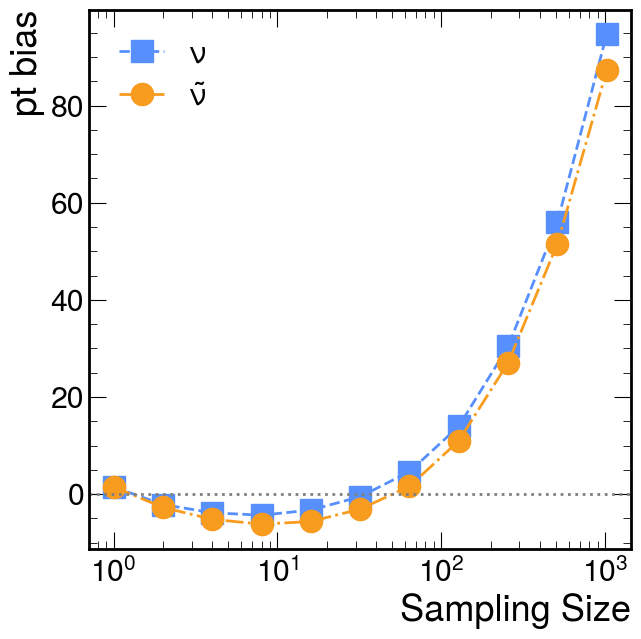

In [42]:
fig = plot('pt', 'bias', sample_size_list, output)

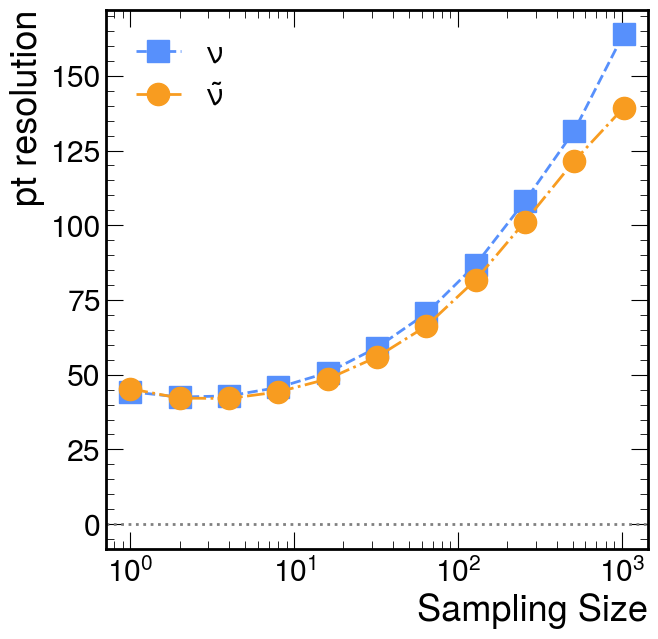

In [43]:
fig = plot('pt', 'resolution', sample_size_list, output)

(-0.02, 0.02)

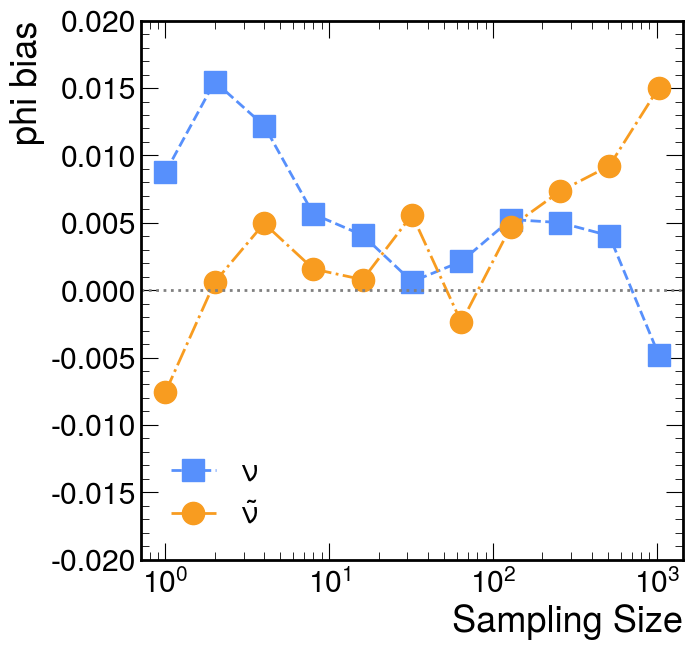

In [47]:
fig = plot('phi', 'bias', sample_size_list, output)
fig.get_axes()[0].set_ylim(-0.02, +0.02)

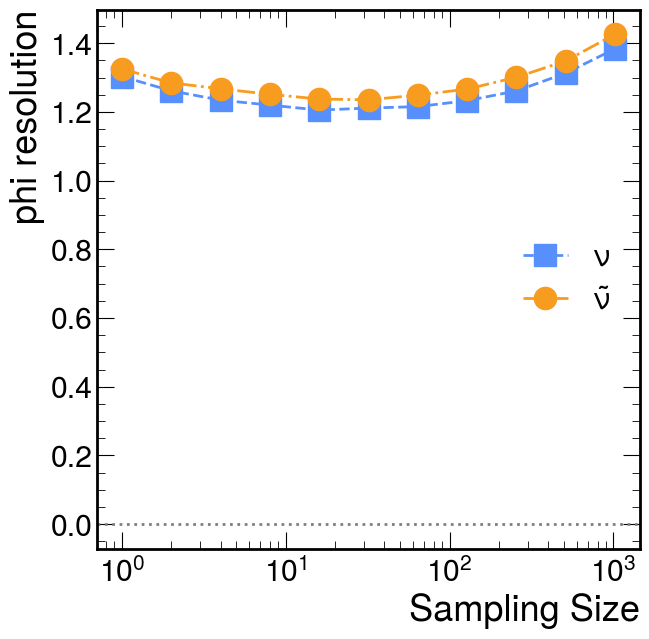

In [45]:
fig = plot('phi', 'resolution', sample_size_list, output)